In [1]:
!pip install datasets

In [2]:
import torch
from diffusers import DPMSolverMultistepScheduler, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from datasets import load_dataset, load_from_disk
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import tqdm

# Configuration du UNet avec checkpointing
from torch.utils.checkpoint import checkpoint

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Charger le modèle pré-entraîné
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

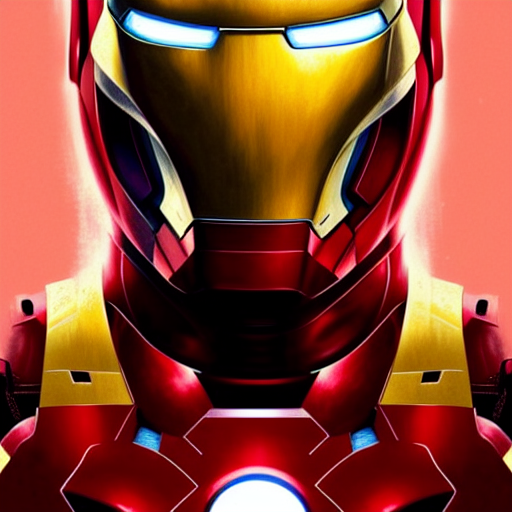

In [4]:
# Test du modèle pré-entraîné
prompt = "Elon musk as iron man realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting,  art by artgerm and greg rutkowski and alphonse mucha" #@param {type:'string'}

image = pipe(prompt).images[0]
image

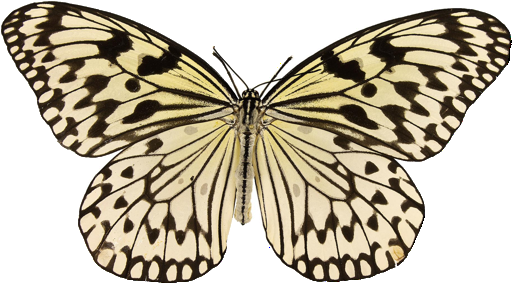

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6', 'image_alt': 'view Paper Kite digital asset number 1', 'id': 'ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6', 'name': 'Paper Kite', 'scientific_name': 'Idea leuconoe', 'gender': None, 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae', 'region': 'US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)', 'locality': 'NMNH Butterfly Pavilion, North America, United States, District of Columbia', 'date': None, 'usnm_no': 'EO401041', 'guid': 'http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-a33c-611d7b358636', 'edan_url': 'edanmdm:nmnheducation_11038234', 'source': 'Smithsonian Education and Outreach collections', 'stage': None, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283 at 0x79946757FD90>, 'image_hash': 'fb0b8749d437efc70a26e54212b3572c', 'sim_score': 0.8055200576782227}
1000
['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 

In [7]:
# Téléchargement du dataset
dataset_path = "huggan/smithsonian_butterflies_subset"
DATASET_EXISTS = True

if DATASET_EXISTS :
  dataset = load_from_disk(dataset_path)
else :
  dataset = load_dataset(dataset_path, split="train")
  dataset.save_to_disk(dataset_path)


display(dataset[0]["image"])
print(dataset[0])
print(len(dataset))
# Affiche les clés et types de données disponibles
print(dataset.column_names)


In [8]:
# Classe pour encapsuler le dataset et appliquer les transformations
class CustomImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),  # Redimensionner
            transforms.ToTensor(),         # Convertir en Tensor
            transforms.Normalize([0.5], [0.5])  # Normalisation
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Récupérer l'image brute
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image


# Créer le dataset personnalisé avec transformations
custom_dataset = CustomImageDataset(dataset)

# Créer un DataLoader pour gérer le batch processing
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

# Testez un batch pour vérifier
for batch in dataloader:
    print(batch.shape)  # Devrait afficher torch.Size([batch_size, 3, 512, 512])
    break


torch.Size([1, 3, 512, 512])


In [9]:
# Chargement du tokenizer et du text encoder
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16)

class UNetWithCheckpointing(UNet2DConditionModel):
    def forward(self, *args, **kwargs):
        def custom_forward(*inputs):
            return super(UNetWithCheckpointing, self).forward(*inputs, **kwargs)

        return checkpoint(custom_forward, *args, use_reentrant=False)

# Ramplacer UNet avec la version avec checkpointe
unet = UNetWithCheckpointing.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16)
unet = unet.to("cuda")

text_encoder = text_encoder.to("cuda", dtype=torch.float16)


In [10]:
# Optimiseur et Scheduler
optimizer = AdamW(unet.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

# Charger le planificateur de bruit (DDPM)
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Texte de conditionnement
conditioning_text = "A photo of a Paper Kite"

# Tokenisation du texte
text_inputs = tokenizer(
    conditioning_text,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    return_tensors="pt",
)
text_embeddings = text_encoder(text_inputs.input_ids.to("cuda")).last_hidden_state
text_embeddings = text_embeddings.repeat(batch.size(0), 1, 1)
text_embeddings = text_embeddings.to("cuda", dtype=torch.float16).requires_grad_()
print(f"Adjusted Text embeddings shape: {text_embeddings.shape}")

Adjusted Text embeddings shape: torch.Size([1, 77, 768])


In [11]:
# Paramètres d'entraînement
num_epochs = 5  # Ajustez selon vos besoins
gradient_accumulation_steps = 2  # Pour ajuster la mémoire GPU

# Geler les couches sauf la dernière
for name, param in unet.named_parameters():
    param.requires_grad = name.startswith('Conv_out')

# Boucle d'entraînement
for epoch in range(num_epochs):
    unet.train()  # Mettre le modèle en mode entraînement

    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for step, batch in enumerate(pbar):
        batch = batch.to("cuda", dtype=torch.float16).requires_grad_()

        # Ajouter un canal supplémentaire pour que l'image ait 4 canaux pour correspondre au modèle
        batch = torch.cat([batch, torch.zeros_like(batch[:, :1])], dim=1)

        # Générer des étapes aléatoires pour la diffusion
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch.size(0),)).to("cuda").to(torch.long)

        # Ajouter du bruit aux images
        noise = torch.randn_like(batch).to("cuda").to(torch.float16)  # Générer du bruit
        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy_images = noisy_images.to(torch.float16)
        noisy_images = noisy_images[:, :4, :, :]

        # Prédiction du bruit par le modèle
        noise_pred = unet(
            sample=noisy_images,  # Les images bruitées
            timestep=timesteps,  # Étapes temporelles
            encoder_hidden_states=text_embeddings.to(torch.float16),  # Texte encodé en float16
        )["sample"]

        # Calcul de la perte
        loss = nn.MSELoss()(noise_pred, noise)

        # Backpropagation
        loss.backward()

        # Mise à jour des poids après accumulation des gradients
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            # Clear unused memory to prevent GPU memory fragmentation
            torch.cuda.empty_cache()

        # Mise à jour de la barre de progression
        pbar.set_postfix({"loss": loss.item()})

print("Entraînement terminé 🎉")


Epoch 1/5:   0%|          | 0/1000 [02:30<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 407.06 MiB is free. Process 193254 has 14.35 GiB memory in use. Of the allocated memory 14.07 GiB is allocated by PyTorch, and 142.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Sauvegarder le modèle UNet
unet.save_pretrained("./fine_tuned_unet")
tokenizer.save_pretrained("./fine_tuned_tokenizer")
text_encoder.save_pretrained("./fine_tuned_text_encoder")
